# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.3.0+cpu'

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 60

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_mrocs import StaticReacherProxy, N_REWARDS, f_reward
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        h_rewards = rewards.clone()
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1

            h_rewards[i] = torch.tensor(f_reward(s, n, g, None, True, None, None))
            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()
        return ( h_rewards, h_goals, states, h_n_goals, n_states )

def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau, her_delay):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, lr_critic,
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
    
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]
#        cind = 1, gae=True, n_step=4, floating_step=False, gamma=.99, gae_tau=.95, her_delay=None) for h in her ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=5, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=lr_critic, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
BS = 512
PPOBS = 2048
bpo_brain = [

        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 5, batch_size=PPOBS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 10) // 3,
            optim_epochs=1, optim_batch_size=1*PPOBS,  recalc_delay=3,
            
            lr_actor=1e-3, learning_delay=1*MAX_STEPS, learning_repeat=6,
            sync_delta_a=2, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=True),

        BrainDescription(
            memory_size=20 * MAX_STEPS * 200, batch_size=BS, 
            optim_pool_size=70000, optim_epochs=2, optim_batch_size=3*BS, recalc_delay=5,
            lr_actor=3e-5, learning_delay=10, learning_repeat=3,
            sync_delta_a=1, sync_delta_c=1, tau_actor=1e-1, tau_critic=1e-1,
            bellman=True, ppo_eps=None, natural=False, mean_only=True, separate_actors=False),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[6000, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 16000, '<- optim_pool_size;', 3, '<- recalc_delay;', 2, '<- sync_delta_a;', 1, '<- sync_delta_c;', 60, '<- learning_delay;', 6, '<- learning_repeat;', 0.001, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;'], [240000, '<- memory_size;', 512, '<- batch_size;', 2, '<- optim_epochs;', 1536, '<- optim_batch_size;', 70000, '<- optim_pool_size;', 5, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 10, '<- learning_delay;', 3, '<- learning_repeat;', 3e-05, '<- lr_actor;', 0.1, '<- tau_actor;', 0.1, '<- tau_critic;', None, '<- ppo_eps;', False, '<- natural;', True, '<- mean_only;']]


## 9. LEARN!

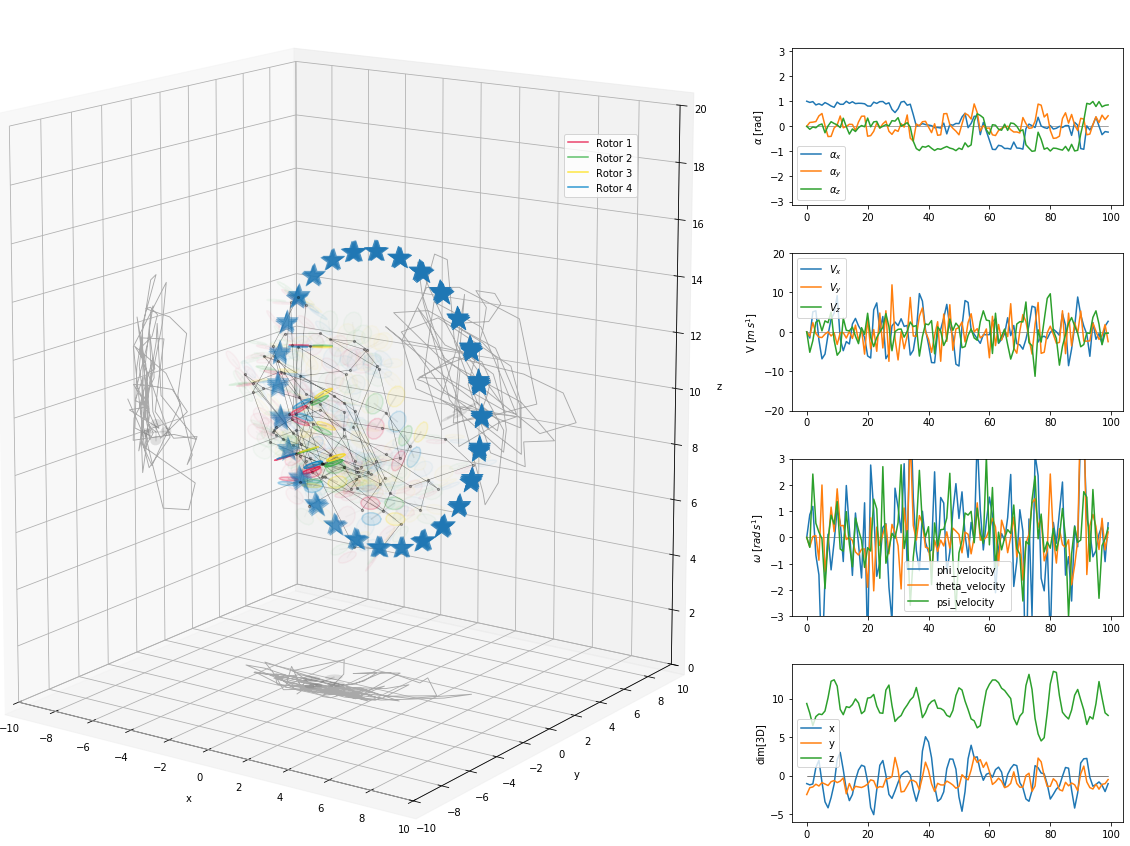

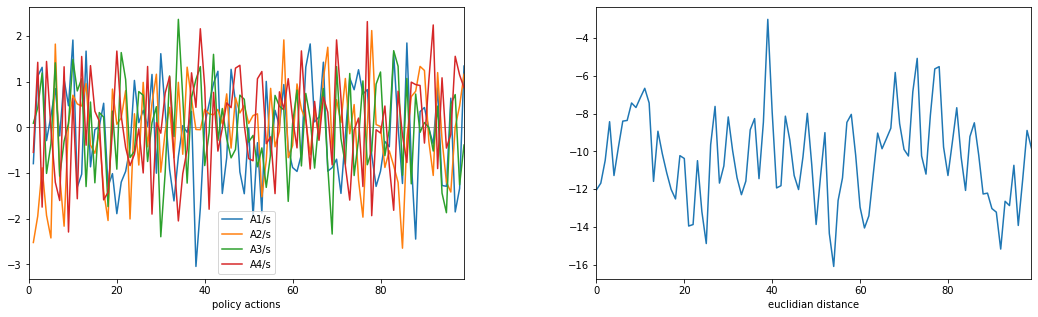

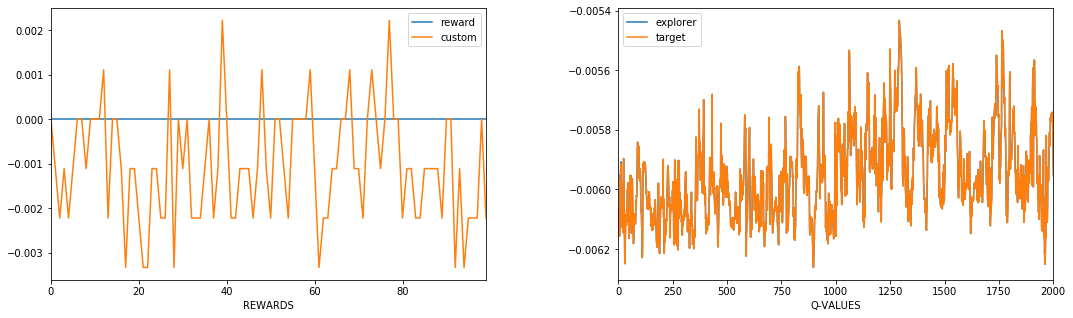

[   19>  1139:: 0] steps =   59, max_step =  60/ 60, reward=-0.020722 <action=tensor([ 0.1304,  1.1604,  1.2292, -0.5439])>                                    
	 [ 19 ] < 178.98 sec > TEST ==>  [[tensor(0.5550)], [tensor(0.5490)]] exploring score: tensor(-0.0214)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%    92.69ms/cyc @     1.0execs/cyc
              learn-round: 100.0%    92.67ms/cyc @     0.2execs/cyc
                    learn: 100.0%    92.67ms/cyc @     0.2execs/cyc
        FullMemory-sample:  76.3%    70.70ms/cyc @     0.0execs/cyc
            _push_to_fast:  65.5%    60.67ms/cyc @    10.3execs/cyc
                   _learn:  25.5%    23.61ms/cyc @     0.3execs/cyc
        FastMemory-sample:  23.6%    21.91ms/cyc @     0.1execs/cyc
                 __call__:  23.6%    21.87ms/cyc @    10.6execs/cyc
                 backprop:  11.2%    10.40ms/cyc @     0.5execs/cyc
                    _push:   4.6%     4.27ms/cyc @     0.3execs/cyc
           

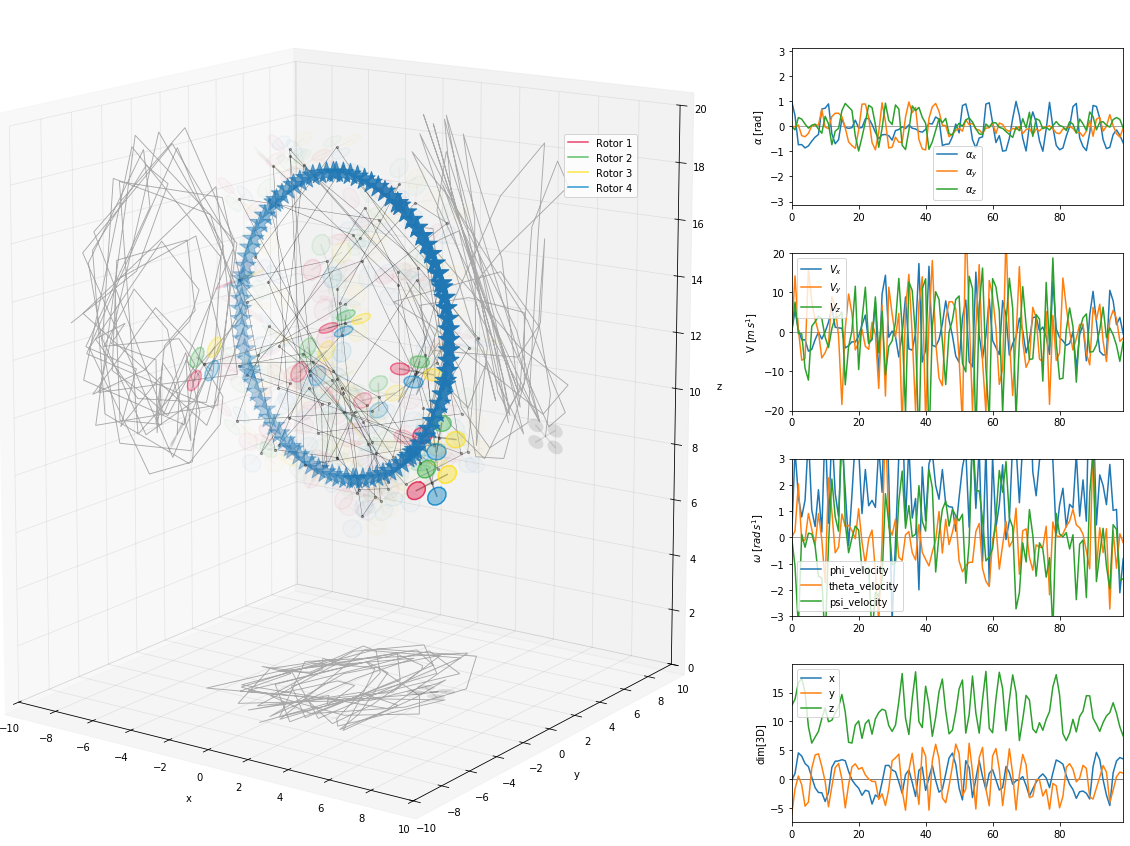

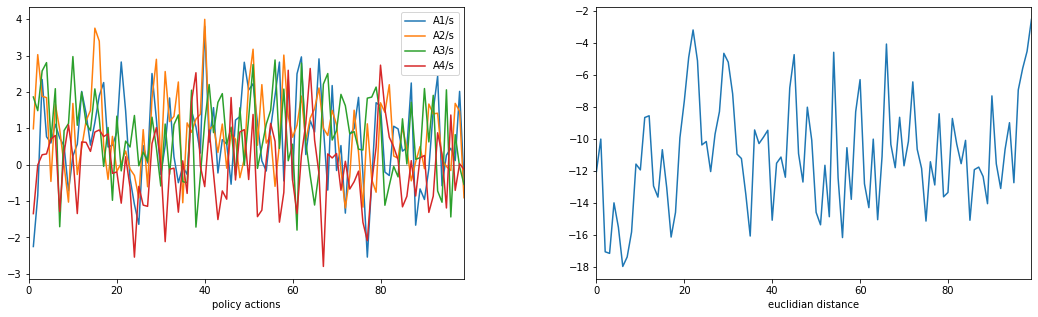

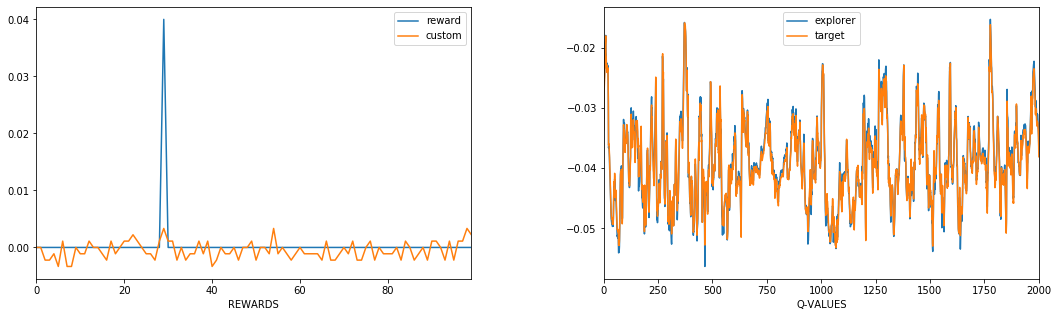

[   39>  2339:: 0] steps =   59, max_step =  60/ 60, reward=0.003278 <action=tensor([ 0.0738, -0.1371,  2.4047, -0.0887])>                                     
	 [ 39 ] < 378.91 sec > TEST ==>  [[tensor(1.5345)], [tensor(1.2820)]] exploring score: tensor(0.0035)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   107.02ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   107.00ms/cyc @     0.2execs/cyc
                    learn: 100.0%   107.00ms/cyc @     0.2execs/cyc
        FullMemory-sample:  78.4%    83.96ms/cyc @     0.0execs/cyc
            _push_to_fast:  67.4%    72.08ms/cyc @    12.1execs/cyc
                 __call__:  24.1%    25.79ms/cyc @    12.4execs/cyc
                   _learn:  23.6%    25.27ms/cyc @     0.3execs/cyc
        FastMemory-sample:  21.5%    22.99ms/cyc @     0.1execs/cyc
                 backprop:  10.3%    11.06ms/cyc @     0.5execs/cyc
                    _push:   6.1%     6.53ms/cyc @     0.3execs/cyc
            

[  199> 11939:: 0] steps =   59, max_step =  60/ 60, reward=0.075889 <action=tensor([-0.7790,  1.5165, -1.8899,  0.3972])>                                    
	 [ 199 ] < 2059.92 sec > TEST ==>  [[tensor(7.9185)], [tensor(7.9705)]] exploring score: tensor(0.0779)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   109.00ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   108.97ms/cyc @     0.2execs/cyc
                    learn: 100.0%   108.97ms/cyc @     0.2execs/cyc
        FullMemory-sample:  78.1%    85.15ms/cyc @     0.0execs/cyc
            _push_to_fast:  67.0%    73.02ms/cyc @    12.6execs/cyc
                   _learn:  23.9%    26.05ms/cyc @     0.3execs/cyc
                 __call__:  23.8%    25.92ms/cyc @    13.0execs/cyc
                    _push:  22.8%    24.81ms/cyc @     0.3execs/cyc
        FastMemory-sample:  21.8%    23.77ms/cyc @     0.2execs/cyc
                 backprop:  10.4%    11.37ms/cyc @     0.6execs/cyc
           

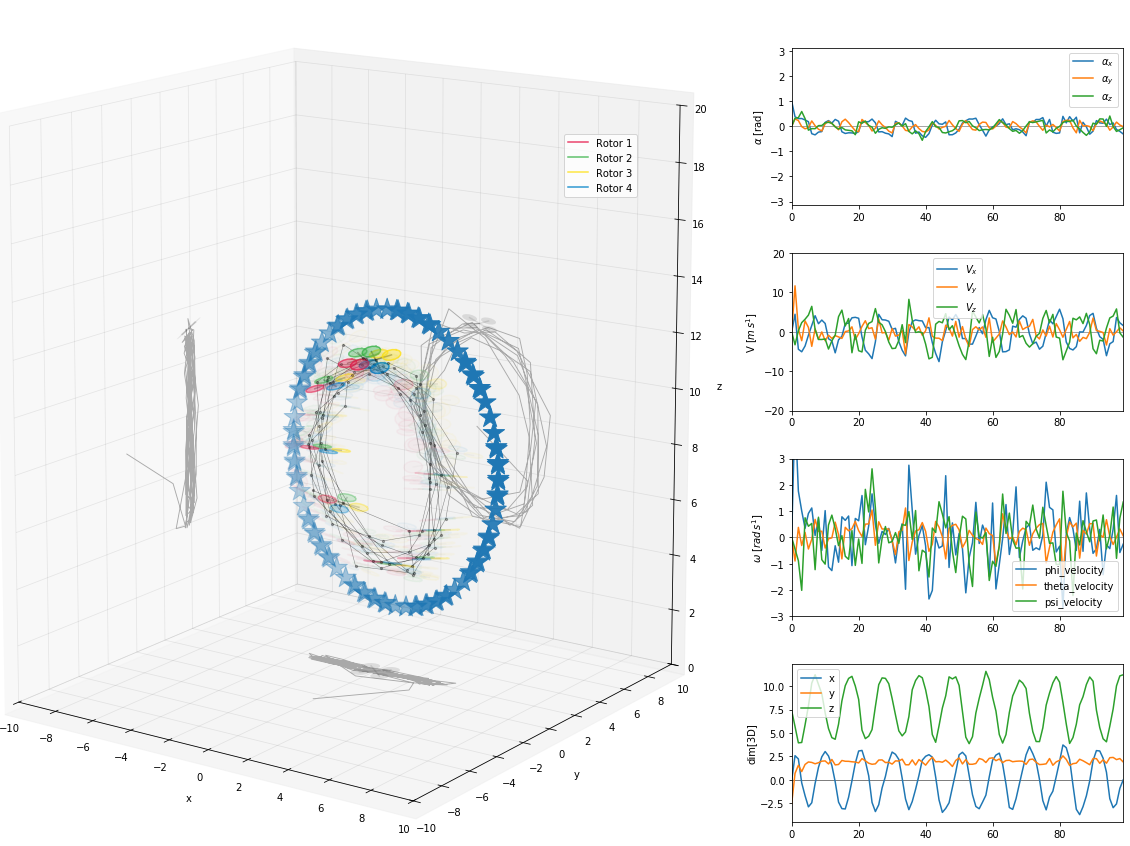

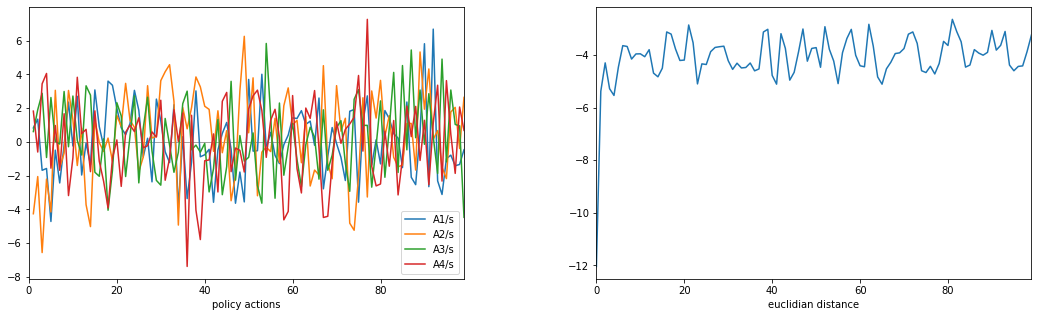

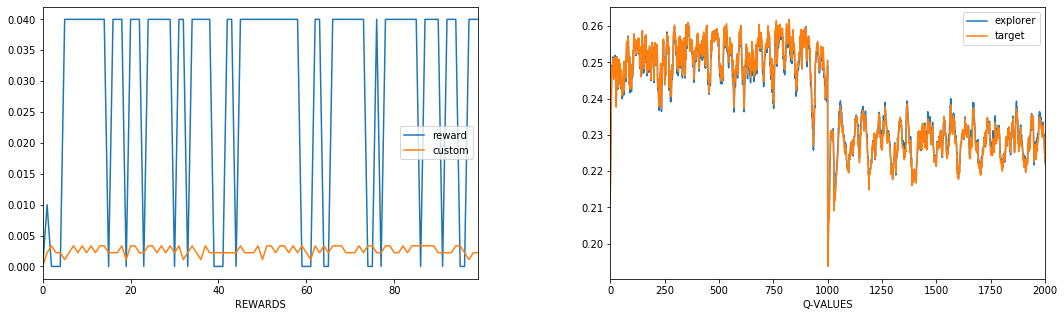

[  339> 20339:: 0] steps =   59, max_step =  60/ 60, reward=0.115278 <action=tensor([-3.4480,  4.8712, -0.9111, -0.2655])>                                    
 environment solved!  30.72969931313768 [array([31.4805493 , 29.97884933])]
[[tensor(31.2590), tensor(31.3930), tensor(31.8570), tensor(31.0080), tensor(30.8435), tensor(33.0985), tensor(32.9020), tensor(30.0320), tensor(31.0895), tensor(31.3230)], [tensor(31.1735), tensor(28.3780), tensor(30.8895), tensor(28.6430), tensor(29.0850), tensor(28.4645), tensor(31.6260), tensor(30.5660), tensor(31.0030), tensor(29.9600)]]

	 [ 339 ] < 3860.26 sec > TEST ==>  [[tensor(31.2590), tensor(31.3930), tensor(31.8570), tensor(31.0080), tensor(30.8435), tensor(33.0985), tensor(32.9020), tensor(30.0320), tensor(31.0895), tensor(31.3230)], [tensor(31.1735), tensor(28.3780), tensor(30.8895), tensor(28.6430), tensor(29.0850), tensor(28.4645), tensor(31.6260), tensor(30.5660), tensor(31.0030), tensor(29.9600)]] exploring score: tensor(0.1173)
timebu

In [10]:
agent, env = new_agent(
    [4, 1], bpo_brain, lr_critic=3e-4,
    goal_encoder=goal_encoder, encoder=encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

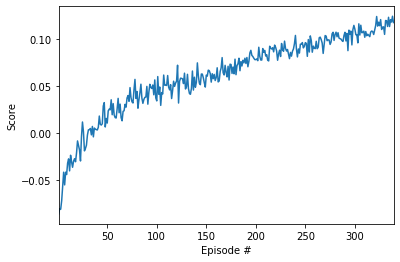

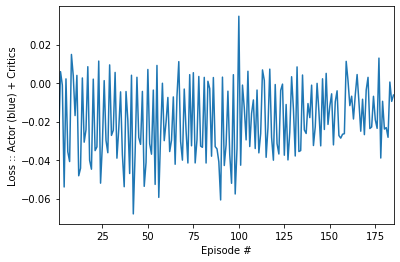

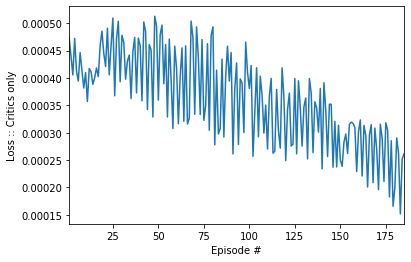

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  30.86789931004866 [array([31.73374929, 30.00204933])]
[[tensor(32.4830), tensor(32.2815), tensor(31.3600), tensor(32.2210), tensor(32.1660), tensor(30.9780), tensor(31.4355), tensor(32.0460), tensor(31.5765), tensor(30.7900)], [tensor(30.9140), tensor(28.5710), tensor(30.7695), tensor(29.5770), tensor(31.4650), tensor(31.2965), tensor(27.7830), tensor(30.2910), tensor(30.2465), tensor(29.1070)]]

 environment solved!  30.883699309695498 [array([31.2721993 , 30.49519932])]
[[tensor(31.6825), tensor(31.2880), tensor(32.5810), tensor(31.2345), tensor(31.3245), tensor(30.4805), tensor(30.7480), tensor(31.5785), tensor(30.1285), tensor(31.6760)], [tensor(29.8190), tensor(30.9025), tensor(31.1605), tensor(30.3765), tensor(30.7910), tensor(29.5250), tensor(28.9435), tensor(31.4520), tensor(31.2895), tensor(30.6925)]]

 environment solved!  31.01967430665622 [array([31.1974493 , 30.84189931])]
[[tensor(30.6245), tensor(31.3055), tensor(32.2275), tensor(32.3030), tensor(2

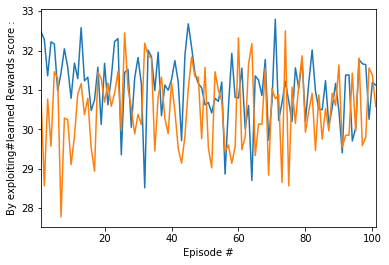

In [14]:
rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER


 environment solved!  32.08992428273429 [array([31.90369929, 32.27614928])]
[[tensor(32.5600), tensor(31.9350), tensor(31.6210), tensor(31.2180), tensor(31.6520), tensor(32.0350), tensor(32.2685), tensor(31.5075), tensor(31.8535), tensor(32.3865)], [tensor(31.7985), tensor(32.0360), tensor(32.5795), tensor(31.3530), tensor(32.5965), tensor(31.1285), tensor(33.7710), tensor(32.5705), tensor(32.5290), tensor(32.3990)]]

 environment solved!  32.023849284211174 [array([31.95919929, 32.08849928])]
[[tensor(31.7470), tensor(33.4330), tensor(31.6230), tensor(32.4175), tensor(32.0555), tensor(30.7405), tensor(31.1080), tensor(31.5705), tensor(33.1885), tensor(31.7085)], [tensor(31.6920), tensor(31.7400), tensor(31.9935), tensor(32.4990), tensor(32.4605), tensor(31.3415), tensor(32.6635), tensor(32.0750), tensor(31.7255), tensor(32.6945)]]

 environment solved!  31.9724742853595 [array([31.63494929, 32.30999928])]
[[tensor(32.1735), tensor(31.4705), tensor(31.5995), tensor(30.2640), tensor(32

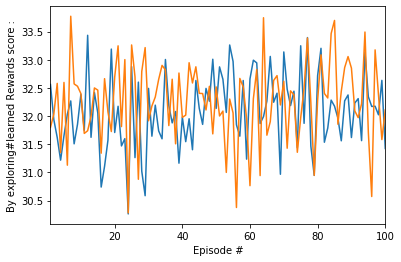

In [15]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()